#### IMPORTANT
Ensure you are utilizing 64-bit REFPROP with 64-bit python. If using the free version of REFPROP (MINI-REFPROP), please use 32-bit python and make changes to match the location where MINI-REFPROP is installed and make changes to the REFPROPFunctionLibrary function to read the REFPROP.DLL file.

Information on REFPROP and functions can be found here: https://buildmedia.readthedocs.org/media/pdf/refprop-docs/latest/refprop-docs.pdf

### IMPORT PACKAGES & FUNCTIONS

In [1]:
# Dictate the environment's loctaion of REFPROP
import os
os.environ['RPPREFIX'] = r'C:/Program Files (x86)/REFPROP'

In [2]:
# Import the main class from the Python library
from ctREFPROP.ctREFPROP import REFPROPFunctionLibrary

# Imports from conda-installable packages
import pandas as pd

# Import numpy
import numpy as np

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Import Math for common values such as PI
import math


In [3]:
# Instantiate the library, and use the environment variable to explicitly state which path we want to use.
# As mentioned above, this will be changed to call the correct REFPROP functions to be used
# with MINI-REFPROP and 32-bit python.
# If using MINI-REFPROP and 32-bit python please make the following changes
# RP = REFPROPFunctionLibrary('C:/Program FIles (x86)/MINI-REFPROP\\REFPROP.DLL')
RP = REFPROPFunctionLibrary(os.environ['RPPREFIX'])

In [4]:
# This will call which root directory that will be used for the program. 
RP.SETPATHdll(os.environ['RPPREFIX'])

In [5]:
# Get the unit system we want to use (Mass base SI gives units in
# K, Pa, kg, m, N, J, W, and s)
MASS_BASE_SI = RP.GETENUMdll(0, "MASS BASE SI").iEnum

### sCO2 Loop Calculations

#### System Parameters

In [6]:
# Tube inner diameter and outer diameter
Tube_OD = 0.50 # [inch]
Tube_Thick = 0.049 # [inch]
Tube_ID = Tube_OD - 2 * Tube_Thick # inch

Tube_OD = Tube_OD * 0.0254 # [Convert inches to meters]
Tube_ID = Tube_ID * 0.0254 # [Convert inches to meters]

# Mass flow rate of sCO2
m_dot = 0.2 # [kg/s]

#### Outlet of Compressor (State  1)

In [7]:
# Temperature will be compared at end of script
T1 = 63 # [C]
P1 = 2500 # [psia]

T1 = T1 + 273.15 # Convert C to Kelvin
P1 = P1 * 6894.8 # convert psia to Pa

print("Pressure at Outlet of Compressor =", P1/6894.8, "psia")
print("Temperature at Outlet of Compressor =" , (T1 - 273.15) * (9/5) + 32, "F")

Pressure at Outlet of Compressor = 2500.0 psia
Temperature at Outlet of Compressor = 145.4 F


In [8]:
# Obtain fluid properties from the pressure and temperature outlined above
State_1 = RP.REFPROPdll("CO2","PT","D;V;H;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P1,T1,[1.0])

# Outputs will be placed into data frame for organization
State_1 = pd.DataFrame(State_1.Output[0:9],
            index = ['Density [kg/m^3]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 1'])

# Display the data frame
State_1

,State 1
Density [kg/m^3],646.530133
Volume [m^3/kg],0.001547
Enthalpy [J/kg],342482.845698
Entropy [J/kg],1412.054091
CP/CV,3.115189
Speed of Sound,346.935076
Thermal Cond. [W/(mK)],0.069987
Viscosity [Pa-s],0.000051
Prandtl,2.117334


#### Pressure drop towards Heat Source

In [9]:
# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * State_1.loc['Volume [m^3/kg]','State 1'] / (math.pi * Tube_ID**2)
Reynolds = State_1.loc['Density [kg/m^3]','State 1'] * Velocity * Tube_ID / State_1.loc['Viscosity [Pa-s]','State 1']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

In [10]:
# Using Estimated Length of Tubing connecting compressor and Heat Source, 
# find the amount of pressure drop caused by fanno flow
Length = 4 # [meters]

# Force acted on the wall of tube
Force = math.pi * Tube_ID * Darcy_f * State_1.loc['Density [kg/m^3]','State 1'] * (Velocity**2) * Length / 8 

# Dimensionless Friction factor
f_dim = 4 * Force / (P1 * math.pi * Tube_ID**2) 

# Inlet Mach Number of length of tubing
Mach_inlet = Velocity / State_1.loc['Speed of Sound','State 1']

# Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
A_eq = ((Mach_inlet**2) * (1 + ((State_1.loc['CP/CV','State 1'] - 1) / 2) * (Mach_inlet**2))) \
        / ((1 + State_1.loc['CP/CV','State 1'] * (Mach_inlet**2) - f_dim)**2)

# Find the positive outcome to the biquadratic Mach number
Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * State_1.loc['CP/CV','State 1'])\
                          + ((1 - 2 * A_eq * (State_1.loc['CP/CV','State 1'] + 1))**0.5))\
                         / ((State_1.loc['CP/CV','State 1'] - 1) - 2 * A_eq * State_1.loc['CP/CV','State 1']**2))

# Find Outlet pressure caused by fanno flow (frictional loss)
P2 = P1 * (1 + State_1.loc['CP/CV','State 1'] * (Mach_inlet**2) - f_dim) / (1 + State_1.loc['CP/CV','State 1']\
                                                                           * (Mach_outlet_1**2))

print("Pressure at Inlet of Heat Source =", round(P2/6894.8 , 3), "psia")

Pressure at Inlet of Heat Source = 2496.547 psia


In [11]:
# Find the enthalpy at the inlet of the Heat Source
Enth_2 = (State_1.loc['Enthalpy [J/kg]','State 1'] * (1 + ((State_1.loc['CP/CV','State 1'] - 1) / 2) * Mach_inlet**2)) / \
            (1 + ((State_1.loc['CP/CV','State 1'] - 1) / 2) * (Mach_outlet_1**2))

Enth_2 # [J/kg]

342482.72683872585

#### Inlet of Heat Source (State 2)

In [12]:
#Pressure and temperature of fluid at inlet of Heat Source
P2 = P2


# Tube ID (using 1" OD Tubes)
Tube_HS_ID = .81 * 0.0254 # convert inches to meters

# Obtain fluid properties from the pressure and temperature outlined above
State_2 = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P2,Enth_2,[1.0])

# Outputs will be placed into data frame for organization
State_2 = pd.DataFrame(State_2.Output[0:9],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 2'])

# Display the data frame
State_2

,State 2
Temperature [K],336.110163
Density [kg/m^3],646.231718
Volume [m^3/kg],0.001547
Entropy [J/kg],1412.163323
CP/CV,3.118738
Speed of Sound,346.604977
Thermal Cond. [W/(mK)],0.069958
Viscosity [Pa-s],0.000051
Prandtl,2.119456


In [13]:
# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * State_2.loc['Volume [m^3/kg]','State 2'] / (math.pi * Tube_HS_ID**2)
Reynolds = State_2.loc['Density [kg/m^3]','State 2'] * Velocity * Tube_HS_ID / State_2.loc['Viscosity [Pa-s]','State 2']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

In [14]:
# Find the amount of Heat Supplied by Heat Tapes
Power = 1245 # [W]
Voltage_1 = 240 # [VAC]
Res = Voltage_1**2 / Power # Resistance per tape
P_act = 208**2 / Res # Actual power into per tape
Voltage_loss = 1.732 * 12.9 * 65 * 67 / 41740 # Voltage lost [%]
V_new = 208 - (208 * Voltage_loss/100) # Voltage that can be supplied to tapes after loss
P_new = V_new**2 / Res # New Power

Q_total_1 = P_new * 18 # 18 Heat Tapes used, Total heat developed

# 1 Heat tape is different with a different power
Power_2 = 940 # [W]
Voltage_2 = 240 # [VAC]
Res_2 = Voltage_2**2 / Power_2 # Resistance per tape
P_act_2 = 208**2 / Res_2 # Actual power into per tape
V_new_2 = 208 - (208 * Voltage_loss/100) # Voltage that can be supplied to tapes after loss
P_new_2 = V_new_2**2 / Res_2 # New Power

Q_total = Q_total_1 + P_new_2 # Total heat added to system

# Find the new heat flux of each tape
q_flux_1 = 13 # [W/in^2] Original heat flux per tape
Q_orig_1 = 1245 * 18 # Original heat provided by tapes
A_orig_1 = Q_orig_1 / q_flux_1 # [in^2]

q_flux_new = Q_total_1 / A_orig_1 # This is valid for all tapes

Q_total

16730.274708409575

In [15]:
# Using Estimated Length of Tubing used by Heat Source 
# find the amount of pressure drop caused by fanno flow and Heat addition
Length = 17.37 # [meters]

# Force acted on the wall of tube
Force = math.pi * Tube_HS_ID * Darcy_f * State_2.loc['Density [kg/m^3]','State 2'] * (Velocity**2) * Length / 8 

# Dimensionless Friction factor
f_dim = 4 * Force / (P2 * math.pi * Tube_HS_ID**2) 

# Heat Added into system (kW)
# Max Heat Possible is 16730 W
Q = 12 # [kW]

# Dimensionless heating factor
q_dim = Q * 1000 / (m_dot * Enth_2)

# Inlet Mach Number of length of tubing
Mach_inlet = Velocity / State_2.loc['Speed of Sound','State 2']

# Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
A_eq = ((Mach_inlet**2) * (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
        / ((1 + State_2.loc['CP/CV','State 2'] * (Mach_inlet**2) - f_dim)**2)

# Find the positive outcome to the biquadratic Mach number
Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * State_2.loc['CP/CV','State 2'])\
                          + ((1 - 2 * A_eq * (State_2.loc['CP/CV','State 2'] + 1))**0.5))\
                         / ((State_2.loc['CP/CV','State 2'] - 1) - 2 * A_eq * State_2.loc['CP/CV','State 2']**2))

# Find Outlet pressure caused by fanno flow (frictional loss)
P3 = P2 * (1 + State_2.loc['CP/CV','State 2'] * (Mach_inlet**2) - f_dim) / (1 + State_2.loc['CP/CV','State 2']\
                                                                           * (Mach_outlet_1**2))



In [16]:
# Find the enthalpy at the outlet of the Heat source
Enth_3 = (Enth_2 * (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * Mach_inlet**2 + q_dim)) / \
            (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * (Mach_outlet_1**2))

Enth_3 # [J/kg]

402481.72796945693

In [17]:
# Find the surface temperature of the tubing with constant heat flux
# 1 Heat Tape covers approximately 3 feet

T_HS_sCO2 = []
T_Sur_HS = []
L_x = []

P_new = P2
Enth_new = Enth_2

for x in range(0,101):
    P_old = P_new # Looping Pressure
    Enth_old = Enth_new # Looping Enthalpy
    
    # Obtain Properties of sCO2
    sCO2_HS_Calc = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P_old,Enth_old,[1.0])
    
    sCO2_HS_Calc = pd.DataFrame(sCO2_HS_Calc.Output[0:9],
                index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
                columns = ['sCO2 HS'])
    
    T_HS_sCO2.append(sCO2_HS_Calc.loc['Temperature [K]','sCO2 HS'])
    
    # Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
    Velocity = 4 * m_dot * sCO2_HS_Calc.loc['Volume [m^3/kg]','sCO2 HS'] / (math.pi * Tube_HS_ID**2)
    Reynolds = sCO2_HS_Calc.loc['Density [kg/m^3]','sCO2 HS'] * Velocity * Tube_HS_ID / sCO2_HS_Calc.loc['Viscosity [Pa-s]','sCO2 HS']
    Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)
    Nus = 0.0243 * Reynolds**(4/5) * (sCO2_HS_Calc.loc['Prandtl', 'sCO2 HS'])**(0.4)
    h_sCO2_HS = Nus * (sCO2_HS_Calc.loc['Thermal Cond. [W/(mK)]', 'sCO2 HS']) / Tube_HS_ID
    
     # Newton's Law of Cooling
    Sur_T = (q_flux_new / .00064516) / h_sCO2_HS + sCO2_HS_Calc.loc['Temperature [K]', 'sCO2 HS']
    T_Sur_HS.append(Sur_T)
    
    # Force acted on the wall of tube
    Force = math.pi * Tube_HS_ID * Darcy_f * sCO2_HS_Calc.loc['Density [kg/m^3]','sCO2 HS'] * (Velocity**2) * Length*(x/100) / 8 

    # Dimensionless Friction factor
    f_dim = 4 * Force / (P2 * math.pi * Tube_HS_ID**2) 

    # Heat Added into system (kW)
    Q = 12000*(x/100)/1000

    # Dimensionless heating factor
    q_dim = Q * 1000 / (m_dot * Enth_2)

    # Inlet Mach Number of length of tubing
    Mach_inlet = Velocity / sCO2_HS_Calc.loc['Speed of Sound','sCO2 HS']

    # Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
    A_eq = ((Mach_inlet**2) * (1 + ((sCO2_HS_Calc.loc['CP/CV','sCO2 HS'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
            / ((1 + sCO2_HS_Calc.loc['CP/CV','sCO2 HS'] * (Mach_inlet**2) - f_dim)**2)

    # Find the positive outcome to the biquadratic Mach number
    Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * sCO2_HS_Calc.loc['CP/CV','sCO2 HS'])\
                              + ((1 - 2 * A_eq * (sCO2_HS_Calc.loc['CP/CV','sCO2 HS'] + 1))**0.5))\
                             / ((sCO2_HS_Calc.loc['CP/CV','sCO2 HS'] - 1) - 2 * A_eq * sCO2_HS_Calc.loc['CP/CV','sCO2 HS']**2))

    # Find Outlet pressure caused by fanno flow (frictional loss)
    P_new = P2 * (1 + sCO2_HS_Calc.loc['CP/CV','sCO2 HS'] * (Mach_inlet**2) - f_dim) / (1 + sCO2_HS_Calc.loc['CP/CV','sCO2 HS']\
                                                                               * (Mach_outlet_1**2))

    Enth_new = (Enth_2 * (1 + ((sCO2_HS_Calc.loc['CP/CV','sCO2 HS'] - 1) / 2) * Mach_inlet**2 + q_dim)) / \
                (1 + ((sCO2_HS_Calc.loc['CP/CV','sCO2 HS'] - 1) / 2) * (Mach_outlet_1**2))
    
    L_x.append(Length*(x/100))


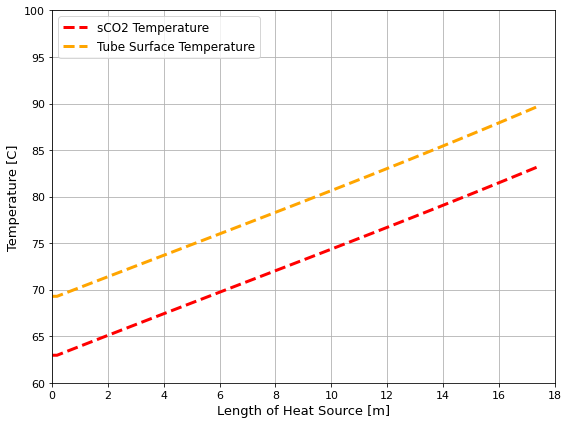

In [18]:
# Plot Surface Temperature 
T_HS_sCO2 = np.array(T_HS_sCO2) - 273.15
T_Sur_HS = np.array(T_Sur_HS) - 273.15

plt.figure(figsize=(8,6), tight_layout=True)

plt.plot(L_x, T_HS_sCO2, 'r--', linewidth = 3 , label = "sCO2 Temperature" )
plt.plot(L_x, T_Sur_HS, '--',color = 'orange' ,linewidth = 3 , label = "Tube Surface Temperature")
plt.grid(True)
plt.axis([0,18,60,100])
plt.xlabel('Length of Heat Source [m]', fontsize = 13)
plt.ylabel('Temperature [C]', fontsize = 13)
plt.legend(loc = "upper left" , fontsize=12)
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)

#plt.savefig('Heat_Source_Surface_Temp.png',bbox_inches='tight')
plt.show()

In [19]:
# Small Section of Piping that is a part of the heat source but not heated

Length = 1.8288 # [meters]

# Force acted on the wall of tube
Force = math.pi * Tube_HS_ID * Darcy_f * State_2.loc['Density [kg/m^3]','State 2'] * (Velocity**2) * Length / 8 

# Dimensionless Friction factor
f_dim = 4 * Force / (P2 * math.pi * Tube_HS_ID**2) 

# Heat Added into system (kW)
# Max Heat Possible is 16730 W
Q = 0 # [kW]

# Dimensionless heating factor
q_dim = Q * 1000 / (m_dot * Enth_2)

# Inlet Mach Number of length of tubing
Mach_inlet = Velocity / State_2.loc['Speed of Sound','State 2']

# Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
A_eq = ((Mach_inlet**2) * (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
        / ((1 + State_2.loc['CP/CV','State 2'] * (Mach_inlet**2) - f_dim)**2)

# Find the positive outcome to the biquadratic Mach number
Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * State_2.loc['CP/CV','State 2'])\
                          + ((1 - 2 * A_eq * (State_2.loc['CP/CV','State 2'] + 1))**0.5))\
                         / ((State_2.loc['CP/CV','State 2'] - 1) - 2 * A_eq * State_2.loc['CP/CV','State 2']**2))

# Find Outlet pressure caused by fanno flow (frictional loss)
P3 = P3 * (1 + State_2.loc['CP/CV','State 2'] * (Mach_inlet**2) - f_dim) / (1 + State_2.loc['CP/CV','State 2']\
                                                                           * (Mach_outlet_1**2))

print("Pressure at Outlet of Heat Source =", round(P3/6894.8 , 3), "psia")

Pressure at Outlet of Heat Source = 2495.934 psia


In [20]:
# Find the enthalpy at the outlet of the Heat source
Enth_3 = (Enth_3 * (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * Mach_inlet**2 + q_dim)) / \
            (1 + ((State_2.loc['CP/CV','State 2'] - 1) / 2) * (Mach_outlet_1**2))

Enth_3 # [J/kg]

402481.72759407054

#### Outlet of Heat Source (State 3)

In [21]:
# Using the new Pressure and enthalpy find the states of the fluid at the outlet of Heat Source

State_3 = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P3,Enth_3,[1.0])

# Outputs will be placed into data frame for organization
State_3 = pd.DataFrame(State_3.Output[0:9],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 3'])

# Display the data frame
State_3

,State 3
Temperature [K],356.533679
Density [kg/m^3],490.114392
Volume [m^3/kg],0.002040
Entropy [J/kg],1585.526965
CP/CV,3.011236
Speed of Sound,295.449169
Thermal Cond. [W/(mK)],0.055971
Viscosity [Pa-s],0.000037
Prandtl,1.818767


In [22]:
# Add enthalpy to the data frame
State_2.loc['Enthalpy [J/kg]', 'State 2'] = Enth_2
State_3.loc['Enthalpy [J/kg]', 'State 3'] = Enth_3

In [23]:
# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * State_3.loc['Volume [m^3/kg]','State 3'] / (math.pi * Tube_ID**2)
Reynolds = State_3.loc['Density [kg/m^3]','State 3'] * Velocity * Tube_ID / State_3.loc['Viscosity [Pa-s]','State 3']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

In [24]:
# Using Estimated Length of Tubing connecting Heat Source and Engine 
# find the amount of pressure drop caused by fanno flow
Length = 2.5 # [meters]

# Force acted on the wall of tube
Force = math.pi * Tube_ID * Darcy_f * State_3.loc['Density [kg/m^3]','State 3'] * (Velocity**2) * Length / 8 

# Dimensionless Friction factor
f_dim = 4 * Force / (P3 * math.pi * Tube_ID**2) 

# Heat Added into system (kW)
Q = 0

# Dimensionless heating factor
q_dim = Q * 1000 / (m_dot * State_3.loc['Enthalpy [J/kg]','State 3'])

# Inlet Mach Number of length of tubing
Mach_inlet = Velocity / State_3.loc['Speed of Sound','State 3']

# Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
A_eq = ((Mach_inlet**2) * (1 + ((State_3.loc['CP/CV','State 3'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
        / ((1 + State_3.loc['CP/CV','State 3'] * (Mach_inlet**2) - f_dim)**2)

# Find the positive outcome to the biquadratic Mach number
Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * State_3.loc['CP/CV','State 3'])\
                          + ((1 - 2 * A_eq * (State_3.loc['CP/CV','State 3'] + 1))**0.5))\
                         / ((State_3.loc['CP/CV','State 3'] - 1) - 2 * A_eq * State_3.loc['CP/CV','State 3']**2))

# Find Outlet pressure caused by fanno flow (frictional loss)
P4 = P3 * (1 + State_3.loc['CP/CV','State 3'] * (Mach_inlet**2) - f_dim) / (1 + State_3.loc['CP/CV','State 3']\
                                                                           * (Mach_outlet_1**2))

print("Pressure at Inlet of Engine =", round(P4/6894.8 , 3), "psia")

Pressure at Inlet of Engine = 2493.246 psia


In [25]:
# Find the enthalpy at the inlet of the Engine
Enth_4 = (State_3.loc['Enthalpy [J/kg]','State 3'] * (1 + ((State_3.loc['CP/CV','State 3'] - 1) / 2) * Mach_inlet**2 + q_dim)) / \
            (1 + ((State_3.loc['CP/CV','State 3'] - 1) / 2) * (Mach_outlet_1**2))

Enth_4 # [J/kg]

402481.4792990186

##### Check order of states before continuing

In [26]:
# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([State_1, State_2, State_3], axis =1)

# Display the data frame to ensure proper layout
sCO2_States

,State 1,State 2,State 3
Density [kg/m^3],646.530133,646.231718,490.114392
Volume [m^3/kg],0.001547,0.001547,0.002040
Enthalpy [J/kg],342482.845698,342482.726839,402481.727594
Entropy [J/kg],1412.054091,1412.163323,1585.526965
CP/CV,3.115189,3.118738,3.011236
Speed of Sound,346.935076,346.604977,295.449169
Thermal Cond. [W/(mK)],0.069987,0.069958,0.055971
Viscosity [Pa-s],0.000051,0.000051,0.000037
Prandtl,2.117334,2.119456,1.818767
Temperature [K],NaN,336.110163,356.533679


In [27]:
# Fill in the Missing data
sCO2_States.loc['Temperature [K]', 'State 1'] = T1
sCO2_States.loc['Pressure [Pa]', 'State 1'] = P1
sCO2_States.loc['Pressure [Pa]', 'State 2'] = P2
sCO2_States.loc['Pressure [Pa]', 'State 3'] = P3

# Display Data Frame
sCO2_States

,State 1,State 2,State 3
Density [kg/m^3],6.465301e+02,6.462317e+02,4.901144e+02
Volume [m^3/kg],1.546718e-03,1.547433e-03,2.040340e-03
Enthalpy [J/kg],3.424828e+05,3.424827e+05,4.024817e+05
Entropy [J/kg],1.412054e+03,1.412163e+03,1.585527e+03
CP/CV,3.115189e+00,3.118738e+00,3.011236e+00
Speed of Sound,3.469351e+02,3.466050e+02,2.954492e+02
Thermal Cond. [W/(mK)],6.998662e-02,6.995850e-02,5.597056e-02
Viscosity [Pa-s],5.068415e-05,5.064784e-05,3.665480e-05
Prandtl,2.117334e+00,2.119456e+00,1.818767e+00
Temperature [K],3.361500e+02,3.361102e+02,3.565337e+02


In [28]:
# Reorder the Data Frame
sCO2_States = sCO2_States.reindex(["Pressure [Pa]", "Temperature [K]", 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]',
                     'Entropy [J/kg]', 'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 
                     'Prandtl' ])

#### Inlet of Engine (State 4)

In [29]:
# Using the new Pressure and enthalpy find the states of the fluid at the Inlet of Engine

State_4 = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P4,Enth_4,[1.0])

# Outputs will be placed into data frame for organization
State_4 = pd.DataFrame(State_4.Output[0:9],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 4'])

# Display the data frame
State_4

,State 4
Temperature [K],356.482123
Density [kg/m^3],489.813061
Volume [m^3/kg],0.002042
Entropy [J/kg],1585.632377
CP/CV,3.013341
Speed of Sound,295.254077
Thermal Cond. [W/(mK)],0.055948
Viscosity [Pa-s],0.000037
Prandtl,1.819651


In [30]:
# Engine Parameters
mass_cylinder = State_4.loc['Density [kg/m^3]', 'State 4'] * .000308276
State_5_den = mass_cylinder / .000454574

# With Isentropic expansion
State_5_entr = State_4.loc['Entropy [J/kg]', 'State 4']

#### Outlet of Engine (State 5)

In [31]:
# Using the new density and entropy find the states of the fluid at the Outlet of Engine

State_5_isen = RP.REFPROPdll("CO2","DS","P;T;V;H;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,State_5_den,State_5_entr,[1.0])

# Outputs will be placed into data frame for organization
State_5_isen = pd.DataFrame(State_5_isen.Output[0:9],
            index = ['Pressure [Pa]', 'Temperature [K]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 5 Isentropic'])

# Display the data frame
State_5_isen

,State 5 Isentropic
Pressure [Pa],8.015994e+06
Temperature [K],3.099678e+02
Volume [m^3/kg],3.010471e-03
Enthalpy [J/kg],3.804766e+05
CP/CV,8.685386e+00
Speed of Sound,1.937128e+02
Thermal Cond. [W/(mK)],5.787615e-02
Viscosity [Pa-s],2.424297e-05
Prandtl,4.211262e+00


In [32]:
# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([sCO2_States, State_4, State_5_isen], axis =1)

# Fill in the Missing data
sCO2_States.loc['Pressure [Pa]', 'State 4'] = P4
sCO2_States.loc['Enthalpy [J/kg]', 'State 4'] = Enth_4
sCO2_States.loc['Density [kg/m^3]', 'State 5 Isentropic'] = State_5_den
sCO2_States.loc['Entropy [J/kg]', 'State 5 Isentropic'] = State_5_entr

# Display the data frame
sCO2_States

,State 1,State 2,State 3,State 4,State 5 Isentropic
Pressure [Pa],1.723700e+07,1.721319e+07,1.720897e+07,1.719043e+07,8.015994e+06
Temperature [K],3.361500e+02,3.361102e+02,3.565337e+02,3.564821e+02,3.099678e+02
Density [kg/m^3],6.465301e+02,6.462317e+02,4.901144e+02,4.898131e+02,3.321739e+02
Volume [m^3/kg],1.546718e-03,1.547433e-03,2.040340e-03,2.041595e-03,3.010471e-03
Enthalpy [J/kg],3.424828e+05,3.424827e+05,4.024817e+05,4.024815e+05,3.804766e+05
Entropy [J/kg],1.412054e+03,1.412163e+03,1.585527e+03,1.585632e+03,1.585632e+03
CP/CV,3.115189e+00,3.118738e+00,3.011236e+00,3.013341e+00,8.685386e+00
Speed of Sound,3.469351e+02,3.466050e+02,2.954492e+02,2.952541e+02,1.937128e+02
Thermal Cond. [W/(mK)],6.998662e-02,6.995850e-02,5.597056e-02,5.594776e-02,5.787615e-02
Viscosity [Pa-s],5.068415e-05,5.064784e-05,3.665480e-05,3.662890e-05,2.424297e-05


In [33]:
# Account for Issentropic Efficiency
Isen_eff = .7
State_5_enth_new = sCO2_States.loc['Enthalpy [J/kg]', 'State 4'] - (Isen_eff * (sCO2_States.loc['Enthalpy [J/kg]', 'State 4'] - sCO2_States.loc['Enthalpy [J/kg]', 'State 5 Isentropic']))

# Using Pressure and enthalpy find the states of the fluid at the Outlet of Engine

State_5 = RP.REFPROPdll("CO2","DH","P;T;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,State_5_den,State_5_enth_new,[1.0])

# Outputs will be placed into data frame for organization
State_5 = pd.DataFrame(State_5.Output[0:9],
            index = ['Pressure [Pa]','Temperature [K]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 5'])

# Display the data frame
State_5

,State 5
Pressure [Pa],8.537993e+06
Temperature [K],3.144717e+02
Volume [m^3/kg],3.010471e-03
Entropy [J/kg],1.601744e+03
CP/CV,6.576835e+00
Speed of Sound,2.026910e+02
Thermal Cond. [W/(mK)],5.271870e-02
Viscosity [Pa-s],2.448830e-05
Prandtl,3.304370e+00


In [34]:
# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([sCO2_States, State_5], axis =1)

# Fill in the Missing data
sCO2_States.loc['Density [kg/m^3]', 'State 5'] = State_5_den
sCO2_States.loc['Enthalpy [J/kg]', 'State 5'] = State_5_enth_new

# Display the data frame
sCO2_States

,State 1,State 2,State 3,State 4,State 5 Isentropic,State 5
Pressure [Pa],1.723700e+07,1.721319e+07,1.720897e+07,1.719043e+07,8.015994e+06,8.537993e+06
Temperature [K],3.361500e+02,3.361102e+02,3.565337e+02,3.564821e+02,3.099678e+02,3.144717e+02
Density [kg/m^3],6.465301e+02,6.462317e+02,4.901144e+02,4.898131e+02,3.321739e+02,3.321739e+02
Volume [m^3/kg],1.546718e-03,1.547433e-03,2.040340e-03,2.041595e-03,3.010471e-03,3.010471e-03
Enthalpy [J/kg],3.424828e+05,3.424827e+05,4.024817e+05,4.024815e+05,3.804766e+05,3.870781e+05
Entropy [J/kg],1.412054e+03,1.412163e+03,1.585527e+03,1.585632e+03,1.585632e+03,1.601744e+03
CP/CV,3.115189e+00,3.118738e+00,3.011236e+00,3.013341e+00,8.685386e+00,6.576835e+00
Speed of Sound,3.469351e+02,3.466050e+02,2.954492e+02,2.952541e+02,1.937128e+02,2.026910e+02
Thermal Cond. [W/(mK)],6.998662e-02,6.995850e-02,5.597056e-02,5.594776e-02,5.787615e-02,5.271870e-02
Viscosity [Pa-s],5.068415e-05,5.064784e-05,3.665480e-05,3.662890e-05,2.424297e-05,2.448830e-05


In [35]:
# Work Analysis of Engine
Isen_Work = m_dot * (sCO2_States.loc['Enthalpy [J/kg]','State 4'] - sCO2_States.loc['Enthalpy [J/kg]','State 5 Isentropic'])
Act_Work = m_dot * (sCO2_States.loc['Enthalpy [J/kg]','State 4'] - sCO2_States.loc['Enthalpy [J/kg]','State 5'])

print("Isentropic Work Produced =", round(Isen_Work/1000 , 4), "kW")
print("Actual Work Produced =", round(Act_Work/1000 , 4), "kW")
print("Difference in Work=", round((Isen_Work - Act_Work)/1000 , 4), "kW")

Isentropic Work Produced = 4.401 kW
Actual Work Produced = 3.0807 kW
Difference in Work= 1.3203 kW


In [36]:
# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * sCO2_States.loc['Volume [m^3/kg]','State 5'] / (math.pi * Tube_ID**2)
Reynolds = sCO2_States.loc['Density [kg/m^3]','State 5'] * Velocity * Tube_ID / sCO2_States.loc['Viscosity [Pa-s]','State 5']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

In [37]:
# Using Estimated Length of Tubing connecting Engine and Heat Exchanger 
# find the amount of pressure drop caused by fanno flow
Length = 12.3 # [meters]

# Force acted on the wall of tube
Force = math.pi * Tube_ID * Darcy_f * sCO2_States.loc['Density [kg/m^3]','State 5'] * (Velocity**2) * Length / 8 

# Dimensionless Friction factor
f_dim = 4 * Force / (sCO2_States.loc['Pressure [Pa]','State 5'] * math.pi * Tube_ID**2) 

# Heat Added into system (kW)
Q = 0

# Dimensionless heating factor
q_dim = Q * 1000 / (m_dot * sCO2_States.loc['Enthalpy [J/kg]','State 5'])

# Inlet Mach Number of length of tubing
Mach_inlet = Velocity / sCO2_States.loc['Speed of Sound','State 5']

# Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
A_eq = ((Mach_inlet**2) * (1 + ((sCO2_States.loc['CP/CV','State 5'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
        / ((1 + sCO2_States.loc['CP/CV','State 5'] * (Mach_inlet**2) - f_dim)**2)

# Find the positive outcome to the biquadratic Mach number
Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * sCO2_States.loc['CP/CV','State 5'])\
                          + ((1 - 2 * A_eq * (sCO2_States.loc['CP/CV','State 5'] + 1))**0.5))\
                         / ((sCO2_States.loc['CP/CV','State 5'] - 1) - 2 * A_eq * sCO2_States.loc['CP/CV','State 5']**2))

# Find Outlet pressure caused by fanno flow (frictional loss)
P6 = sCO2_States.loc['Pressure [Pa]','State 5'] * (1 + sCO2_States.loc['CP/CV','State 5'] * (Mach_inlet**2) - f_dim) / (1 + sCO2_States.loc['CP/CV','State 5']\
                                                                           * (Mach_outlet_1**2))

print("Pressure at Inlet of Heat Exchanger =", round(P6/6894.8 , 3), "psia")

Pressure at Inlet of Heat Exchanger = 1219.981 psia


In [38]:
# Find the enthalpy at the inlet of the Heat Exchanger
Enth_6 = (sCO2_States.loc['Enthalpy [J/kg]','State 5'] * (1 + ((sCO2_States.loc['CP/CV','State 5'] - 1) / 2) * Mach_inlet**2 + q_dim)) / \
            (1 + ((sCO2_States.loc['CP/CV','State 5'] - 1) / 2) * (Mach_outlet_1**2))

Enth_6 # [J/kg]

387035.3522082437

#### Inlet of Heat Exchanger (State 6)

In [39]:
# Using the new Pressure and enthalpy find the states of the fluid at the Inlet of Heat Exchanger

State_6 = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P6,Enth_6,[1.0])

# Outputs will be placed into data frame for organization
State_6 = pd.DataFrame(State_6.Output[0:9],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 6'])

# Display the data frame
State_6

,State 6
Temperature [K],313.578902
Density [kg/m^3],328.196026
Volume [m^3/kg],0.003047
Entropy [J/kg],1602.828164
CP/CV,6.709353
Speed of Sound,201.294090
Thermal Cond. [W/(mK)],0.052792
Viscosity [Pa-s],0.000024
Prandtl,3.357419


In [40]:
# Add enthalpy and Pressure to Data frame
State_6.loc['Enthalpy [J/kg]', 'State 6'] = Enth_6
State_6.loc['Pressure [Pa]', 'State 6'] = P6

# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([sCO2_States, State_6], axis =1)

# Display the data frame
sCO2_States

,State 1,State 2,State 3,State 4,State 5 Isentropic,State 5,State 6
Pressure [Pa],1.723700e+07,1.721319e+07,1.720897e+07,1.719043e+07,8.015994e+06,8.537993e+06,8.411522e+06
Temperature [K],3.361500e+02,3.361102e+02,3.565337e+02,3.564821e+02,3.099678e+02,3.144717e+02,3.135789e+02
Density [kg/m^3],6.465301e+02,6.462317e+02,4.901144e+02,4.898131e+02,3.321739e+02,3.321739e+02,3.281960e+02
Volume [m^3/kg],1.546718e-03,1.547433e-03,2.040340e-03,2.041595e-03,3.010471e-03,3.010471e-03,3.046960e-03
Enthalpy [J/kg],3.424828e+05,3.424827e+05,4.024817e+05,4.024815e+05,3.804766e+05,3.870781e+05,3.870354e+05
Entropy [J/kg],1.412054e+03,1.412163e+03,1.585527e+03,1.585632e+03,1.585632e+03,1.601744e+03,1.602828e+03
CP/CV,3.115189e+00,3.118738e+00,3.011236e+00,3.013341e+00,8.685386e+00,6.576835e+00,6.709353e+00
Speed of Sound,3.469351e+02,3.466050e+02,2.954492e+02,2.952541e+02,1.937128e+02,2.026910e+02,2.012941e+02
Thermal Cond. [W/(mK)],6.998662e-02,6.995850e-02,5.597056e-02,5.594776e-02,5.787615e-02,5.271870e-02,5.279212e-02
Viscosity [Pa-s],5.068415e-05,5.064784e-05,3.665480e-05,3.662890e-05,2.424297e-05,2.448830e-05,2.424143e-05


In [41]:
# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * sCO2_States.loc['Volume [m^3/kg]','State 6'] / (math.pi * Tube_ID**2)
Reynolds = sCO2_States.loc['Density [kg/m^3]','State 6'] * Velocity * Tube_ID / sCO2_States.loc['Viscosity [Pa-s]','State 6']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

In [42]:
# Using Estimated Length of Tubing used for Heat Exchanger
# find the amount of pressure drop caused by fanno flow & Heat loss
Length = 13.4 # [meters]

# Force acted on the wall of tube
Force = math.pi * Tube_ID * Darcy_f * sCO2_States.loc['Density [kg/m^3]','State 6'] * (Velocity**2) * Length / 8 

# Dimensionless Friction factor
f_dim = 4 * Force / (sCO2_States.loc['Pressure [Pa]','State 6'] * math.pi * Tube_ID**2) 

# Heat into system (kW)
Q = -7.786

# Dimensionless heating factor
q_dim = Q * 1000 / (m_dot * sCO2_States.loc['Enthalpy [J/kg]','State 6'])

# Inlet Mach Number of length of tubing
Mach_inlet = Velocity / sCO2_States.loc['Speed of Sound','State 6']

# Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
A_eq = ((Mach_inlet**2) * (1 + ((sCO2_States.loc['CP/CV','State 6'] - 1) / 2) * (Mach_inlet**2) + q_dim)) \
        / ((1 + sCO2_States.loc['CP/CV','State 6'] * (Mach_inlet**2) - f_dim)**2)

# Find the positive outcome to the biquadratic Mach number
Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * sCO2_States.loc['CP/CV','State 6'])\
                          + ((1 - 2 * A_eq * (sCO2_States.loc['CP/CV','State 6'] + 1))**0.5))\
                         / ((sCO2_States.loc['CP/CV','State 6'] - 1) - 2 * A_eq * sCO2_States.loc['CP/CV','State 6']**2))

# Find Outlet pressure caused by fanno flow (frictional loss)
P7 = sCO2_States.loc['Pressure [Pa]','State 6'] * (1 + sCO2_States.loc['CP/CV','State 6'] * (Mach_inlet**2) - f_dim) / (1 + sCO2_States.loc['CP/CV','State 6']\
                                                                           * (Mach_outlet_1**2))

print("Pressure at Outlet of Heat Exchanger =", round(P7/6894.8 , 3), "psia")

Pressure at Outlet of Heat Exchanger = 1200.924 psia


#### Outlet of Heat Exchanger (State 7)

In [43]:
# Using the new Pressure and Temperature find the properties of the fluid at the Outlet of Heat Exchanger
T7 = 36.5 + 273.15 # [K] will be controlled by cooling loop of Heat Exchanger

State_7 = RP.REFPROPdll("CO2","PT","D;V;H;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P7,T7,[1.0])

# Outputs will be placed into data frame for organization
State_7 = pd.DataFrame(State_7.Output[0:9],
            index = ['Density [kg/m^3]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 7'])

# Display the data frame
State_7

,State 7
Density [kg/m^3],444.407597
Volume [m^3/kg],0.002250
Enthalpy [J/kg],348226.042251
Entropy [J/kg],1479.267386
CP/CV,18.100435
Speed of Sound,187.370847
Thermal Cond. [W/(mK)],0.080422
Viscosity [Pa-s],0.000031
Prandtl,8.804742


In [44]:
# Add Pressure and Temperature to Data frame
State_7.loc['Pressure [Pa]', 'State 7'] = P7
State_7.loc['Temperature [K]', 'State 7'] = T7

# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([sCO2_States, State_7], axis =1)

# Display the data frame
sCO2_States

,State 1,State 2,State 3,State 4,State 5 Isentropic,State 5,State 6,State 7
Pressure [Pa],1.723700e+07,1.721319e+07,1.720897e+07,1.719043e+07,8.015994e+06,8.537993e+06,8.411522e+06,8.280134e+06
Temperature [K],3.361500e+02,3.361102e+02,3.565337e+02,3.564821e+02,3.099678e+02,3.144717e+02,3.135789e+02,3.096500e+02
Density [kg/m^3],6.465301e+02,6.462317e+02,4.901144e+02,4.898131e+02,3.321739e+02,3.321739e+02,3.281960e+02,4.444076e+02
Volume [m^3/kg],1.546718e-03,1.547433e-03,2.040340e-03,2.041595e-03,3.010471e-03,3.010471e-03,3.046960e-03,2.250187e-03
Enthalpy [J/kg],3.424828e+05,3.424827e+05,4.024817e+05,4.024815e+05,3.804766e+05,3.870781e+05,3.870354e+05,3.482260e+05
Entropy [J/kg],1.412054e+03,1.412163e+03,1.585527e+03,1.585632e+03,1.585632e+03,1.601744e+03,1.602828e+03,1.479267e+03
CP/CV,3.115189e+00,3.118738e+00,3.011236e+00,3.013341e+00,8.685386e+00,6.576835e+00,6.709353e+00,1.810044e+01
Speed of Sound,3.469351e+02,3.466050e+02,2.954492e+02,2.952541e+02,1.937128e+02,2.026910e+02,2.012941e+02,1.873708e+02
Thermal Cond. [W/(mK)],6.998662e-02,6.995850e-02,5.597056e-02,5.594776e-02,5.787615e-02,5.271870e-02,5.279212e-02,8.042202e-02
Viscosity [Pa-s],5.068415e-05,5.064784e-05,3.665480e-05,3.662890e-05,2.424297e-05,2.448830e-05,2.424143e-05,3.095520e-05


In [45]:
# Find Velocity, Reynolds Number, and darcy friction factor (assuming smooth pipe)
Velocity = 4 * m_dot * sCO2_States.loc['Volume [m^3/kg]','State 7'] / (math.pi * Tube_ID**2)
Reynolds = sCO2_States.loc['Density [kg/m^3]','State 7'] * Velocity * Tube_ID / sCO2_States.loc['Viscosity [Pa-s]','State 7']
Darcy_f = (0.79 * math.log(Reynolds) - 1.64)**(-2)

In [46]:
# Using Estimated Length of Tubing connecting Heat Exchanger and Compressor 
# find the amount of pressure drop caused by fanno flow 
Length = 6.12 # [meters]

# Force acted on the wall of tube
Force = math.pi * Tube_ID * Darcy_f * sCO2_States.loc['Density [kg/m^3]','State 7'] * (Velocity**2) * Length / 8 

# Dimensionless Friction factor
f_dim = 4 * Force / (sCO2_States.loc['Pressure [Pa]','State 7'] * math.pi * Tube_ID**2) 

# Inlet Mach Number of length of tubing
Mach_inlet = Velocity / sCO2_States.loc['Speed of Sound','State 7']

# Formulation used to calculate Pressure drop (found in Adv. Fluid Mechanics Textbook)
A_eq = ((Mach_inlet**2) * (1 + ((sCO2_States.loc['CP/CV','State 7'] - 1) / 2) * (Mach_inlet**2))) \
        / ((1 + sCO2_States.loc['CP/CV','State 7'] * (Mach_inlet**2) - f_dim)**2)

# Find the positive outcome to the biquadratic Mach number
Mach_outlet_1 = math.sqrt((-1 * (1 - 2 * A_eq * sCO2_States.loc['CP/CV','State 7'])\
                          + ((1 - 2 * A_eq * (sCO2_States.loc['CP/CV','State 7'] + 1))**0.5))\
                         / ((sCO2_States.loc['CP/CV','State 7'] - 1) - 2 * A_eq * sCO2_States.loc['CP/CV','State 7']**2))

# Find Outlet pressure caused by fanno flow (frictional loss)
P8 = (sCO2_States.loc['Pressure [Pa]','State 7']) * (1 + sCO2_States.loc['CP/CV','State 7'] * (Mach_inlet**2) - f_dim) / (1 + sCO2_States.loc['CP/CV','State 7'] * (Mach_outlet_1**2))

print("Pressure at Inlet of Compressor =", round(P8/6894.8 , 3), "psia")

Pressure at Inlet of Compressor = 1193.774 psia


In [47]:
# Find the enthalpy at the inlet of the Compressor
Enth_8 = (sCO2_States.loc['Enthalpy [J/kg]','State 7'] * (1 + ((sCO2_States.loc['CP/CV','State 7'] - 1) / 2) * Mach_inlet**2)) / \
            (1 + ((sCO2_States.loc['CP/CV','State 7'] - 1) / 2) * (Mach_outlet_1**2))

Enth_8 # [J/kg]

348195.7147048735

#### Inlet of Compressor (State 8)

In [48]:
# Using the new Pressure and Enthalpy find the properties of the fluid at the Inlet of Compressor

State_8 = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P8,Enth_8,[1.0])

# Outputs will be placed into data frame for organization
State_8 = pd.DataFrame(State_8.Output[0:9],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 8'])

# Display the data frame
State_8

,State 8
Temperature [K],309.367541
Density [kg/m^3],442.696832
Volume [m^3/kg],0.002259
Entropy [J/kg],1479.528520
CP/CV,19.008456
Speed of Sound,186.232196
Thermal Cond. [W/(mK)],0.081519
Viscosity [Pa-s],0.000031
Prandtl,9.149064


In [49]:
# Add Pressure and Enthalpy to Data frame
State_8.loc['Pressure [Pa]', 'State 8'] = P8
State_8.loc['Enthalpy [J/kg]', 'State 8'] = Enth_8

# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([sCO2_States, State_8], axis =1)

# Display the data frame
sCO2_States

,State 1,State 2,State 3,State 4,State 5 Isentropic,State 5,State 6,State 7,State 8
Pressure [Pa],1.723700e+07,1.721319e+07,1.720897e+07,1.719043e+07,8.015994e+06,8.537993e+06,8.411522e+06,8.280134e+06,8.230832e+06
Temperature [K],3.361500e+02,3.361102e+02,3.565337e+02,3.564821e+02,3.099678e+02,3.144717e+02,3.135789e+02,3.096500e+02,3.093675e+02
Density [kg/m^3],6.465301e+02,6.462317e+02,4.901144e+02,4.898131e+02,3.321739e+02,3.321739e+02,3.281960e+02,4.444076e+02,4.426968e+02
Volume [m^3/kg],1.546718e-03,1.547433e-03,2.040340e-03,2.041595e-03,3.010471e-03,3.010471e-03,3.046960e-03,2.250187e-03,2.258882e-03
Enthalpy [J/kg],3.424828e+05,3.424827e+05,4.024817e+05,4.024815e+05,3.804766e+05,3.870781e+05,3.870354e+05,3.482260e+05,3.481957e+05
Entropy [J/kg],1.412054e+03,1.412163e+03,1.585527e+03,1.585632e+03,1.585632e+03,1.601744e+03,1.602828e+03,1.479267e+03,1.479529e+03
CP/CV,3.115189e+00,3.118738e+00,3.011236e+00,3.013341e+00,8.685386e+00,6.576835e+00,6.709353e+00,1.810044e+01,1.900846e+01
Speed of Sound,3.469351e+02,3.466050e+02,2.954492e+02,2.952541e+02,1.937128e+02,2.026910e+02,2.012941e+02,1.873708e+02,1.862322e+02
Thermal Cond. [W/(mK)],6.998662e-02,6.995850e-02,5.597056e-02,5.594776e-02,5.787615e-02,5.271870e-02,5.279212e-02,8.042202e-02,8.151860e-02
Viscosity [Pa-s],5.068415e-05,5.064784e-05,3.665480e-05,3.662890e-05,2.424297e-05,2.448830e-05,2.424143e-05,3.095520e-05,3.082086e-05


#### Outlet of Compressor (RELOOP)

In [50]:
# Find the Isentropic Outlet of the Compressor
State_1_isen = RP.REFPROPdll("CO2","PS","T;D;V;H;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,P1,sCO2_States.loc['Entropy [J/kg]', 'State 8'],[1.0])
State_1_isen = pd.DataFrame(State_1_isen.Output[0:9],
            index = ['Temperature [K]','Density [kg/m^3]', 'Volume [m^3/kg]', 'Enthalpy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 1 Isentropic'])

# Display the data frame
State_1_isen

,State 1 Isentropic
Temperature [K],343.878208
Density [kg/m^3],584.405800
Volume [m^3/kg],0.001711
Enthalpy [J/kg],365425.107680
CP/CV,3.190633
Speed of Sound,319.986171
Thermal Cond. [W/(mK)],0.064186
Viscosity [Pa-s],0.000044
Prandtl,2.066608


In [51]:
# Add Pressure and Entropy to Data frame
State_1_isen.loc['Pressure [Pa]', 'State 1 Isentropic'] = P1
State_1_isen.loc['Entropy [J/kg]', 'State 1 Isentropic'] = sCO2_States.loc['Entropy [J/kg]', 'State 8']

# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([sCO2_States, State_1_isen], axis =1)

# Display the data frame
sCO2_States

,State 1,State 2,State 3,State 4,State 5 Isentropic,State 5,State 6,State 7,State 8,State 1 Isentropic
Pressure [Pa],1.723700e+07,1.721319e+07,1.720897e+07,1.719043e+07,8.015994e+06,8.537993e+06,8.411522e+06,8.280134e+06,8.230832e+06,1.723700e+07
Temperature [K],3.361500e+02,3.361102e+02,3.565337e+02,3.564821e+02,3.099678e+02,3.144717e+02,3.135789e+02,3.096500e+02,3.093675e+02,3.438782e+02
Density [kg/m^3],6.465301e+02,6.462317e+02,4.901144e+02,4.898131e+02,3.321739e+02,3.321739e+02,3.281960e+02,4.444076e+02,4.426968e+02,5.844058e+02
Volume [m^3/kg],1.546718e-03,1.547433e-03,2.040340e-03,2.041595e-03,3.010471e-03,3.010471e-03,3.046960e-03,2.250187e-03,2.258882e-03,1.711140e-03
Enthalpy [J/kg],3.424828e+05,3.424827e+05,4.024817e+05,4.024815e+05,3.804766e+05,3.870781e+05,3.870354e+05,3.482260e+05,3.481957e+05,3.654251e+05
Entropy [J/kg],1.412054e+03,1.412163e+03,1.585527e+03,1.585632e+03,1.585632e+03,1.601744e+03,1.602828e+03,1.479267e+03,1.479529e+03,1.479529e+03
CP/CV,3.115189e+00,3.118738e+00,3.011236e+00,3.013341e+00,8.685386e+00,6.576835e+00,6.709353e+00,1.810044e+01,1.900846e+01,3.190633e+00
Speed of Sound,3.469351e+02,3.466050e+02,2.954492e+02,2.952541e+02,1.937128e+02,2.026910e+02,2.012941e+02,1.873708e+02,1.862322e+02,3.199862e+02
Thermal Cond. [W/(mK)],6.998662e-02,6.995850e-02,5.597056e-02,5.594776e-02,5.787615e-02,5.271870e-02,5.279212e-02,8.042202e-02,8.151860e-02,6.418639e-02
Viscosity [Pa-s],5.068415e-05,5.064784e-05,3.665480e-05,3.662890e-05,2.424297e-05,2.448830e-05,2.424143e-05,3.095520e-05,3.082086e-05,4.436648e-05


In [52]:
# Account for Issentropic Efficiency
Isen_eff = .85
State_1_enth_new = sCO2_States.loc['Enthalpy [J/kg]', 'State 8'] + (Isen_eff * (sCO2_States.loc['Enthalpy [J/kg]', 'State 1 Isentropic'] - sCO2_States.loc['Enthalpy [J/kg]', 'State 8']))

In [53]:
State_1_new = RP.REFPROPdll("CO2","PH","T;D;V;S;CP/CV;W;TCX;VIS;PRANDTL", MASS_BASE_SI,0,0,sCO2_States.loc['Pressure [Pa]', 'State 1 Isentropic'],State_1_enth_new,[1.0])

# Outputs will be placed into data frame for organization
State_1_new = pd.DataFrame(State_1_new.Output[0:9],
            index = ['Temperature [K]', 'Density [kg/m^3]', 'Volume [m^3/kg]', 'Entropy [J/kg]',
                     'CP/CV', 'Speed of Sound', 'Thermal Cond. [W/(mK)]', 'Viscosity [Pa-s]', 'Prandtl'],
            columns = ['State 1 New'])

# Display the data frame
State_1_new

,State 1 New
Temperature [K],343.013892
Density [kg/m^3],591.311970
Volume [m^3/kg],0.001691
Entropy [J/kg],1472.003581
CP/CV,3.188766
Speed of Sound,322.513493
Thermal Cond. [W/(mK)],0.064807
Viscosity [Pa-s],0.000045
Prandtl,2.076977


In [54]:
# Add Pressure and Entropy to Data frame
State_1_new.loc['Pressure [Pa]', 'State 1 New'] = P1
State_1_new.loc['Enthalpy [J/kg]', 'State 1 New'] = State_1_enth_new

# Combine the data frames into one data frame for ease of use
sCO2_States = pd.concat([sCO2_States, State_1_new], axis =1)

# Display the data frame
sCO2_States

,State 1,State 2,State 3,State 4,State 5 Isentropic,State 5,State 6,State 7,State 8,State 1 Isentropic,State 1 New
Pressure [Pa],1.723700e+07,1.721319e+07,1.720897e+07,1.719043e+07,8.015994e+06,8.537993e+06,8.411522e+06,8.280134e+06,8.230832e+06,1.723700e+07,1.723700e+07
Temperature [K],3.361500e+02,3.361102e+02,3.565337e+02,3.564821e+02,3.099678e+02,3.144717e+02,3.135789e+02,3.096500e+02,3.093675e+02,3.438782e+02,3.430139e+02
Density [kg/m^3],6.465301e+02,6.462317e+02,4.901144e+02,4.898131e+02,3.321739e+02,3.321739e+02,3.281960e+02,4.444076e+02,4.426968e+02,5.844058e+02,5.913120e+02
Volume [m^3/kg],1.546718e-03,1.547433e-03,2.040340e-03,2.041595e-03,3.010471e-03,3.010471e-03,3.046960e-03,2.250187e-03,2.258882e-03,1.711140e-03,1.691155e-03
Enthalpy [J/kg],3.424828e+05,3.424827e+05,4.024817e+05,4.024815e+05,3.804766e+05,3.870781e+05,3.870354e+05,3.482260e+05,3.481957e+05,3.654251e+05,3.628407e+05
Entropy [J/kg],1.412054e+03,1.412163e+03,1.585527e+03,1.585632e+03,1.585632e+03,1.601744e+03,1.602828e+03,1.479267e+03,1.479529e+03,1.479529e+03,1.472004e+03
CP/CV,3.115189e+00,3.118738e+00,3.011236e+00,3.013341e+00,8.685386e+00,6.576835e+00,6.709353e+00,1.810044e+01,1.900846e+01,3.190633e+00,3.188766e+00
Speed of Sound,3.469351e+02,3.466050e+02,2.954492e+02,2.952541e+02,1.937128e+02,2.026910e+02,2.012941e+02,1.873708e+02,1.862322e+02,3.199862e+02,3.225135e+02
Thermal Cond. [W/(mK)],6.998662e-02,6.995850e-02,5.597056e-02,5.594776e-02,5.787615e-02,5.271870e-02,5.279212e-02,8.042202e-02,8.151860e-02,6.418639e-02,6.480743e-02
Viscosity [Pa-s],5.068415e-05,5.064784e-05,3.665480e-05,3.662890e-05,2.424297e-05,2.448830e-05,2.424143e-05,3.095520e-05,3.082086e-05,4.436648e-05,4.501711e-05
